# Project milestone 4
Tadaa - Jonathan Haenni, Lea Schmidt, Danny Kohler
> This work presents the creative extension of the publication from J. Penney : "Chilling effects : Online surveillance and Wikipedia use".

---

## Abstract
The goal of this work is to observe if the public action of Greta Thunberg and her continual incitation for people to educate themselves on the subject of climate change has actually made a difference. This effect would be diametrically different from a chilling effect in that it pushes people to get educated on a subject, effectively arguably increasing their levels of freedom. This effect shall henceforth be called an "Empowering effect".

First and foremost, the selected interest period depends on the choice of events that will be the pivots of the interrupted time series analysis. (ITS) These events are as follows: the school strike of August 20, 2018 led by Greta Thunberg, the 2018 United Nations Climate Change Conference (COP24) on December 14, 2018 and the summit of the United Nations on September 23, 2019. The period of analysis is between January 2018 and February 2020. As seen in HW1, the Covid-19 pandemic influences the pageviews a lots and we will therefore not elongate this analysis onto 2020.

The data considered here comes from Wikipedia. We will consider 150 [ADAPT VALUE] Wikipedia articles divided into 3 groups. The first group is the treatment dataset, containing the Wikipedia articles related to climate change issues. The second group is a quasi-control group, where the topics considered are related to nature, without being related to climate change directly. The third group is another control group composed of popular articles simply reflecting the trends on Wikipedia. It is the same as the one used in the publication. The data sets considered give the number of pageviews per day for each article, within the time period considered.

As already hinted at, the analysis will be very similar to the one used in the publication - an ITS analysis with segmented linear regressions.

If the first group features significant changes in pageviews and the control groups don't across the selected period, we will be able to conclude that the "Empowering Effect" exists and we will be able to compare it to the chilling effect considered in the publication.

---

## 1. Data loading and filtering

> code description

In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

# Load the climate change articles data
art_cc1 = pd.read_csv('data/pageviews-10-pro.csv').copy()
art_cc2 = pd.read_csv('data/pageviews-20-pro.csv').copy()
art_cc3 = pd.read_csv('data/pageviews-30-pro.csv').copy()
art_cc4 = pd.read_csv('data/pageviews-40-pro.csv').copy()
art_cc5 = pd.read_csv('data/pageviews-50-pro.csv').copy()

# Load the control (popular) articles data
art_control1 = pd.read_csv('data/pageviews-10-control.csv').copy()
art_control2 = pd.read_csv('data/pageviews-20-control.csv').copy()
art_control3 = pd.read_csv('data/pageviews-30-control.csv').copy()
art_control4 = pd.read_csv('data/pageviews-40-control.csv').copy()
#art_control5 = pd.read_csv('data/pageviews-50-control.csv').copy()

# Load the climate change articles science data
sci_art_cc1 = pd.read_csv('data/Pro_climate/pageviews-group1-biodiv.csv').copy()
sci_art_cc2 = pd.read_csv('data/Pro_climate/pageviews-group1-energy.csv').copy()
sci_art_cc3 = pd.read_csv('data/Pro_climate/pageviews-group1-meteo.csv').copy()
sci_art_cc4 = pd.read_csv('data/Pro_climate/pageviews-group1-pesticides.csv').copy()
sci_art_cc5 = pd.read_csv('data/Pro_climate/pageviews-groupe1-earth.csv').copy()

# Load the control articles science data
sci_art_control1 = pd.read_csv('data/Group_control/pageviews-group2-anatomy.csv').copy()
sci_art_control2 = pd.read_csv('data/Group_control/pageviews-group2-genetics.csv').copy()
sci_art_control3 = pd.read_csv('data/Group_control/pageviews-group2-optic.csv').copy()
sci_art_control4 = pd.read_csv('data/Group_control/pageviews-group2-philo.csv').copy()
sci_art_control5 = pd.read_csv('data/Group_control/pageviews-group2-social.csv').copy()

# Merge all datasets together for each corpus
art_cc=art_cc1.merge(art_cc2).merge(art_cc3).merge(art_cc4).merge(art_cc5)
art_control=art_control1.merge(art_control2).merge(art_control3).merge(art_control4)#.merge(art_control5)
sci_art_cc=sci_art_cc1.merge(sci_art_cc2).merge(sci_art_cc3).merge(sci_art_cc4).merge(sci_art_cc5)
sci_art_control=sci_art_control1.merge(sci_art_control2).merge(sci_art_control3).merge(sci_art_control4).merge(sci_art_control5)

# Display to illustrate the structure
art_control.head()

,Date,Keanu Reeves,Freddie Mercury,List of highest-grossing films,Ted Bundy,Chernobyl disaster,Joker,List of Marvel Cinematic Universe films,Avengers: Endgame,Billie Eilish,...,India,Michael Jordan,The Beatles,Venom,Barack Obama,New York City,Jason Momoa,Facebook,Millie Bobby Brown,Once Upon a Time in Hollywood
0,2018-01-01,23376,41612,39321,12301,6855,176,33525,38,3071,...,25716,14932,14694,407,20396,29579,22491,23951,23436,0
1,2018-01-02,18217,17525,34241,11654,8369,219,33360,10,3489,...,32794,15537,12617,528,19637,19933,20131,25019,23641,0
2,2018-01-03,24872,12716,29450,12447,8957,209,29134,11,3751,...,30876,16124,12564,503,22417,20296,20808,27744,24889,0
3,2018-01-04,18654,12621,27118,11718,11888,178,27534,17,4162,...,31401,18752,12715,498,20881,18112,19602,25977,20850,0
4,2018-01-05,17674,12407,25787,10768,12103,240,28231,19,4069,...,29565,21127,24112,465,20061,17256,21141,33260,20353,0


In [ ]:
# # Translate dates in datetime type
# art_cc.Date=pd.to_datetime(art_cc.Date)
# art_control.Date=pd.to_datetime(art_control.Date)

# # Set the date as the index
# art_cc=art_cc.set_index('Date')
# art_control=art_control.set_index('Date')

# # Agregate the data by months
# art_cc=art_cc.groupby(pd.Grouper(freq="M")).sum()
# art_control=art_control.groupby(pd.Grouper(freq="M")).sum()

# # Display to illustrate the structure
# display(art_control.head())

# # At this point, we should  sum over all articles.
# art_cc=art_cc.sum(axis=1)
# art_control=art_control.sum(axis=1)

# # Here the index is reset to get the number of months instead of dates, as in the publication.
# # The date column is then removed : it is not needed anymore
# # The pageviews column is renamed
# art_cc=art_cc.reset_index()
# art_cc=art_cc.drop('Date', axis=1)
# art_cc.columns=['pageviews']

# art_control=art_control.reset_index()
# art_control=art_control.drop('Date', axis=1)
# art_control.columns=['pageviews']

# # Display to illustrate the structure
# display(art_control.head())

>Here we have a function to aggregate the dataframe. It creates a dataframe with the index as the datetimes by month and with two columns as the number of the month and the pageviews count over all the article during the said month. 

In [16]:
#Je propose cette fonction pour aggréger directement mais en pouvant choisir quel article drop 
#s'il y a des outliers. En plus les dates sont en index ce qui permet d'utiliser les features de Pandas

def aggregate(df, freq="M", drop = None, normalization=False) :
    """A function to aggregate the dataframe as a Serie sorted by month
    with the total number of pageviews per month. With the numbering of each
    month of the timeserie. drop is used to drop a list of articles in the 
    dataframe. freq is used to choice the frequency of the aggregation. Return the dataframe"""
    df=df.copy()
    df.index=df.Date
    df.index=pd.to_datetime(df.index)
    df=df.drop(columns="Date")
    #Recreate the dataframe without the named articles
    if not drop == None :
        df=df.drop(columns=drop)
    
    # At this point, we should  sum over all articles.
    df=df.sum(axis=1)
    # Agregate the data by months
    df=df.groupby(pd.Grouper(freq=freq)).sum()
    #Serie to dataframe
    df=df.to_frame()
    #Rename the column
    df.columns=['pageviews']
    #Add the column months to help to plot with the regression
    months=np.arange(1, len(df.index)+1)
    df["months"]=months
    
    # Apply normalization
    if normalization :
        max_value = df["pageviews"].max()
        df["pageviews"]=df["pageviews"].apply(lambda x: x/max_value)
    
    return df

art_cc_agg=aggregate(df=art_cc, normalization=True)
art_control_agg=aggregate(df=art_control, normalization=True)
sci_art_cc_agg=aggregate(df=sci_art_cc, normalization=True)
sci_art_control_agg=aggregate(df=sci_art_control, normalization=True)


display(sci_art_cc_agg)

,pageviews,months
Date,,
2017-01-31,0.978295,1
2017-02-28,0.919070,2
2017-03-31,1.000000,3
2017-04-30,0.897990,4
2017-05-31,0.940889,5
2017-06-30,0.893121,6
2017-07-31,0.832797,7
2017-08-31,0.822961,8
2017-09-30,0.934926,9


---

## 2. Computing the Segmented Regression parameters

>Here we define all the intervals between the mentioned event about the climate : the school strike of August 20, 2018 led by Greta Thunberg, the 2018 United Nations Climate Change Conference (COP24) on December 14, 2018 and the summit of the United Nations on September 23, 2019. The modularity of the code allows to simply add or put out an event without changing the code.

In [22]:
INTERVALS =[["2018-01","2018-07"],["2018-08","2018-11"],["2018-12","2019-08"],["2019-09","2020-02"]]
#1er janvier 2017 jusquau 31 aout 2020
INTERVALS2 =[["2017-01","2018-07"],["2018-08","2018-11"],["2018-12","2019-08"],["2019-09","2020-08"]]

>Here we define a function to compute multiple linear regression according to intervals given as arguments. The function returns a dict with the summary of the results, the predicted values corresponding to the given pageviews/month dataframe and the upper/lower values of the confidence intervals for each regression.

In [27]:
import statsmodels.formula.api as smf
import datetime
from statsmodels.stats.outliers_influence import summary_table

def list_LR_periods(df, intervals, CI=0.05) :
    """Compute the linear regression over all the periods given as a list parameters (intervals)
    The confidence intervals (Mean) are extracted from the summary table. All the results are structured
    in a dictionnary and given as output."""
    
    results_dict={}
    
    #iterate through the intervals to compute their regression.
    for interval, number_int in zip(intervals, list(range(1,len(intervals)+1,1))) :
        #Linear regression with pageviews as dependent variable and months independent variables. 
        mod = smf.ols(formula="pageviews ~ months", data=df.loc[interval[0]:interval[1]])
        res=mod.fit()
        #Compute the serie of predicted values from the basic linear equation with one variable : y = intercept + coef * x
        pages_predict=res.params[0]+res.params[1]*df.loc[interval[0]:interval[1]]["months"]
        #Extract the computed values (including upper and lower CI values)
        _, summary_values, summary_names = summary_table(res, alpha=CI)
        #Create a temporary dataframe with the result
        df_res_tmp = pd.DataFrame(summary_values, columns=summary_names)
        #display(df_res_tmp)  -> To see how the data is structured
        #WARNING : It's a bit tricky but the column has always 95% in its name even if the CI
        #introduce in alpha is different of 0.05. It has been tested and the values are different.
        predict_ci_low = df_res_tmp["Mean ci\n95% low"].T
        predict_ci_upp = df_res_tmp["Mean ci\n95% upp"].T
        
        result={
            "results" : res,
            "predicts" : pages_predict,
            "CI" : {
                "lower" : predict_ci_low,
                "upper" : predict_ci_upp
            }
        }
        results_dict[number_int]=result
    return results_dict
                                    

        
#       Create a dictionnary to pass the results. (See the structure below)

 
    #Create a dictionnary to pass the results. The structure is as follow :
#     dic = {
#         "interval1" :{
#             "result" : res_before,
#             "predicts" : pages_predict_before,
#             "CI" : {
#                 "lower" : predict_ci_low_before,
#                 "upper" : predict_ci_upp_before
#             }
#         }, 
#         "interval2" : {
#             "result" : res_after,
#             "predicts" : pages_predict_after,
#             "CI" : {
#                 "lower" : predict_ci_low_after,
#                 "upper" : predict_ci_upp_after
#             }
#         },
#         ...
#     }

>We can try the function.

In [28]:
art_control_reg=list_LR_periods(df=art_control_agg, intervals=INTERVALS)
art_cc_reg=list_LR_periods(df=art_cc_agg, intervals=INTERVALS)
sci_art_control_reg=list_LR_periods(df=sci_art_control_agg, intervals=INTERVALS2)
sci_art_cc_reg=list_LR_periods(df=sci_art_cc_agg, intervals=INTERVALS2)

print(f"CC | Linear Regression interval 2 :\n\n {art_cc_reg[2]['results'].summary()}\n\n")

CC | Linear Regression interval 2 :

                             OLS Regression Results                            
Dep. Variable:              pageviews   R-squared:                       0.712
Model:                            OLS   Adj. R-squared:                  0.568
Method:                 Least Squares   F-statistic:                     4.939
Date:                Wed, 09 Dec 2020   Prob (F-statistic):              0.156
Time:                        14:21:34   Log-Likelihood:                 7.5547
No. Observations:                   4   AIC:                            -11.11
Df Residuals:                       2   BIC:                            -12.34
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     

C:\Users\Jonathan\anaconda3\envs\ada\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


---

## 3. Displaying the results


>Here we have a function to plot two dataframes, generally the studied group of Wikipedia articles and a selected comparator group. Each event is display with a vertical bar to separator each period.

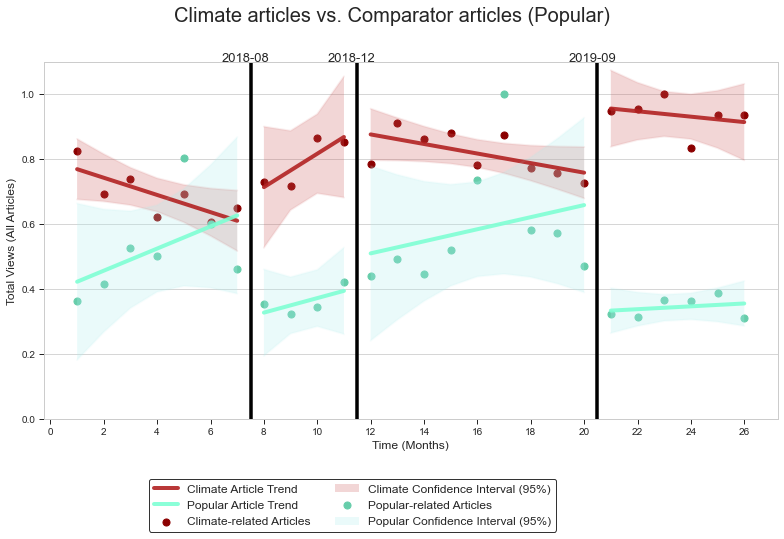

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
plt.style.use('seaborn-whitegrid')

def plot_comparator(dfs, lin_reg_res, params)  :
    """Function that plots the data to compare 2 ITS. It must be given the results of 
    the linear regression and the timeserie with the numbering by month. As the linear
    regression function, it is possible to specify the interval of months for each period.
    All the params are given through dictionnary. The dataframes are given as a tuple and the
    corresponding results of the linear regression as well. The confidence area for each linear
    regression is plotted as an area.
    As follow : (df_studied, df_comparator)"""
    
    #~~~~~~~~~~~~~~~~~~~~~~ Extract parameter ~~~~~~~~~~~~~~~~~~~~~~
    keys=params.keys()
    title=params["title"] if "title" in keys else ""
    xlabel=params["xlabel"] if "xlabel" in keys else ""
    ylabel=params["ylabel"] if "ylabel" in keys else ""
    filename=params["filename"] if "filename" in keys else "no_name"
    intervals=params["intervals"] if "intervals" in keys else []#raise("No intervals")
    #Names used to add in the legend
    names=params["names"] if "names" in keys else ["", ""]
    ci=params["ci"] if "ci" in keys else ""
    #axis limits
    TOP=params["top"] if "top" in keys else None
    BOTTOM=params["bottom"] if "bottom" in keys else None
    
    #~~~~~~~~~~~~~~~~~~~~~~ Fix limit of the axes ~~~~~~~~~~~~~~~~~~~~~~ 
    
    #Boundaries of the y-axis, it has been decided to keep them constant instead of relative by % of the
    #max and min value because it is easier to compare plot when the axes are constant
    BOTTOM=0 if BOTTOM is None else BOTTOM
    all_pageviews=[j for i in [list(dfs[0]["pageviews"]), list(dfs[1]["pageviews"])] for j in i]
    MAX=max(all_pageviews)
    TOP=MAX+0.1*MAX if TOP is None else TOP#1500000#100000000 

    #~~~~~~~~~~~~~~~~~~~~~~ Create the empty plot ~~~~~~~~~~~~~~~~~~~~~~
    
    fig, ax = plt.subplots(1,1,figsize= (11,7), sharey = True, sharex = True)
    
    #~~~~~~~~~~~~~~~~~~~~~~ Plotting all the data points of the serie ~~~~~~~~~~~~~~~~~~~~~~
    
    #Choose in advance the colors of the two groups
#     colors=[("black", "dimgray"), ("darkgrey", "silver")]
    colors=[("darkred", "firebrick", "indianred"), ("mediumaquamarine", "aquamarine", "paleturquoise")]
    #Plots the two plots, the second plot is the comparator group
    for df, reg, col, name in zip(dfs, lin_reg_res, colors, names) :
        #Just to have the correct keys for the reg dict and select
        #properly the right period
        name_interval=["-".join(inter) for inter in intervals]
        
        ax.scatter(x=df["months"],y=df["pageviews"], marker="o", s=50, c=col[0], label=f"{name}-related Articles")
        #Plotting linear regression
        for interval, n_inter, key in zip(intervals, name_interval,  list(range(1,len(intervals)+1,1))) :
            ax.plot(df.loc[interval[0]:interval[1]]["months"],
                    reg[key]["predicts"], #Take the data points of the regression from the dict
                    linewidth=4,
                    alpha=0.9,
                    c=col[1],
                    label=f"{name} Article Trend") #{n_inter}
        
        #~~~~~~~~~~~~~~~~~~~~~~ CI plot ~~~~~~~~~~~~~~~~~~~~~~
        #For each regression line, plot the upper CI values as a line and
        #the lower CI values. Filled the area between the two.
        periods = reg.values()
        for period, interval in zip(periods, intervals) :
            for _, ci_array in period["CI"].items() :
                ax.plot(df.loc[interval[0]:interval[1]]["months"],
                        ci_array,
                        linewidth=2,
                        alpha=0.1,
                        c=col[2]
                       )
            #Create a color area representing the CI
            plt.fill_between(df.loc[interval[0]:interval[1]]["months"],
                period["CI"]["lower"],
                period["CI"]["upper"],
                where=period["CI"]["upper"] >= period["CI"]["lower"],
                facecolor=col[2], alpha=0.25, interpolate=True, label=f"{name} Confidence Interval ({ci})")

    #~~~~~~~~~~~~~~~~~~~~~~ Visual modifications of the plot ~~~~~~~~~~~~~~~~~~~~~~
    
    ax.set_ylim(bottom=BOTTOM, top=TOP)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.xaxis.grid(False)
    ax.xaxis.set_major_locator(MultipleLocator(2))
    ax.xaxis.set_minor_locator(AutoMinorLocator(4))
    ax.xaxis.set_tick_params(length = 5, width = 1)
    ax.yaxis.set_tick_params(length = 5, width = 1)
    #Plot tick bars
    ax.ticklabel_format(useOffset=False, style='plain')
    #Plot a vertical line to delimit the 2 intervals.
    #-0.5 to locate the mid of the month. (Since the frequency is end of month)
    for interval, counter in zip(intervals, list(range(1,len(intervals)+1,1)))  :
        #The event is located always as the first month of an interval except the first one
        if counter > 1 :
            event=float(df.loc[interval[0]]["months"]-0.5)
            plt.axvline(x=event, color = 'black', alpha=1, linewidth=3.5)
            #Indicate the mid June (Arbitrary addition values to center the label)
            ax.text(event-1.1, TOP, interval[0], fontsize=13)
    #Use to avoid "duplicates" in the legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='upper left',fontsize=12,bbox_to_anchor=(0.135, -0.15),ncol=2,frameon=True,edgecolor="black")
    fig.tight_layout()
    fig.suptitle(title, y=1.07, fontsize=20)
    
    #~~~~~~~~~~~~~~~~~~~~~~ Save the plot in order to plot it further ~~~~~~~~~~~~~~~~~~~~~~
    
    plt.savefig(f"./plots/{filename}", format="png",bbox_inches='tight')
    
    
    
#Use the function 
params={
    "title" : "Climate articles vs. Comparator articles (Popular)",
    "xlabel" : "Time (Months)",
    "ylabel" : "Total Views (All Articles)",
    "filename" : "climate_vs_comparator2.png",
    "ci" : "95%",
    "names" : ("Climate","Popular"),
    "intervals" : INTERVALS
}
dfs=(art_cc_agg, art_control_agg)
regs=(art_cc_reg, art_control_reg)
plot_comparator(dfs=dfs, lin_reg_res=regs, params=params)

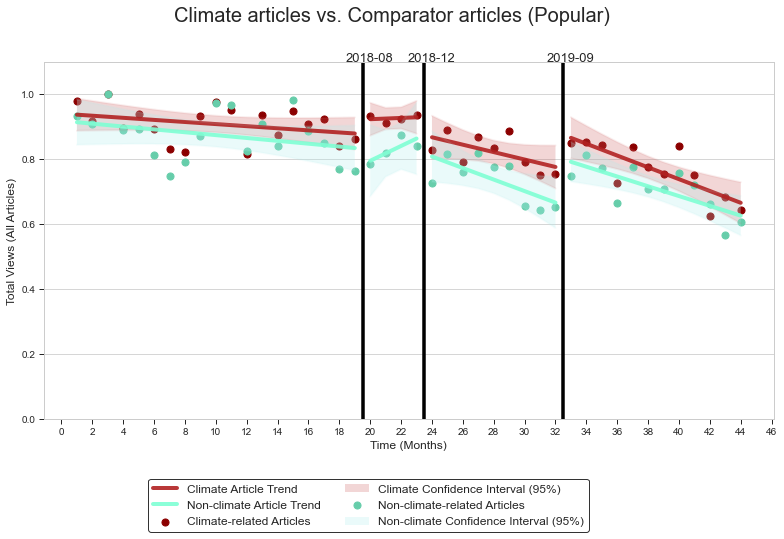

In [30]:
#Use the function for science articles
params={
    "title" : "Climate articles vs. Comparator articles (Popular)",
    "xlabel" : "Time (Months)",
    "ylabel" : "Total Views (All Articles)",
    "filename" : "climate_vs_comparator2.png",
    "ci" : "95%",
    "names" : ("Climate","Non-climate"),
    "intervals" : INTERVALS2
}
dfs=(sci_art_cc_agg, sci_art_control_agg)
regs=(sci_art_cc_reg, sci_art_control_reg)
plot_comparator(dfs=dfs, lin_reg_res=regs, params=params)